#### Import libraries

In [6]:
import os 
import calendar

import numpy as np
import pandas as pd
import xarray as xr

#### Configure paths

In [7]:
CURRENT_DIR = os.getcwd()
REFERENCE_FILE = os.path.join(CURRENT_DIR, '..', '1.-Output_Gridded_data', 'era5SL_010_144x144_kmh_1961-2021.nc')
OBSERVATION_BASE_PATH = os.path.join(CURRENT_DIR, 'SfcWind_hourly_Spain_jan2019-sep2024', 'VientoHorario')
#output_path = os.path.join(CURRENT_DIR, "AEMET_Hourly_2019_144x144_9km.nc")


In [8]:
CURRENT_DIR

'/home/kevin/Escritorio/Kevin/workspace/CRAI_hourly_infilling/WindData_Preprocessing/1.-AEMET'

In [9]:
REFERENCE_FILE

'/home/kevin/Escritorio/Kevin/workspace/CRAI_hourly_infilling/WindData_Preprocessing/1.-AEMET/../1.-Output_Gridded_data/era5SL_010_144x144_kmh_1961-2021.nc'

#### Read ERA-Land data as grid reference

In [10]:
ds_ref = xr.open_dataset(REFERENCE_FILE)

In [11]:
ds_ref

<xarray.Dataset> Size: 2GB
Dimensions:    (longitude: 144, latitude: 144, time: 22280)
Coordinates:
  * longitude  (longitude) float32 576B -9.8 -9.7 -9.6 -9.5 ... 4.2 4.3 4.4 4.5
  * latitude   (latitude) float32 576B 45.9 45.8 45.7 45.6 ... 31.8 31.7 31.6
  * time       (time) datetime64[ns] 178kB 1961-01-01 1961-01-02 ... 2021-12-31
Data variables:
    ws         (time, latitude, longitude) float32 2GB ...
Attributes:
    history:  Daily means from ERA5 0.1º hourly. ERA5 0.1º hourly with sea le...
    author:   Nuria P. Plaza
    date:     2023-03-23

In [12]:
ds_ref['ws']

<xarray.DataArray 'ws' (time: 22280, latitude: 144, longitude: 144)>
[461998080 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -9.8 -9.7 -9.6 -9.5 -9.4 ... 4.2 4.3 4.4 4.5
  * latitude   (latitude) float32 45.9 45.8 45.7 45.6 ... 31.9 31.8 31.7 31.6
  * time       (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2021-12-31

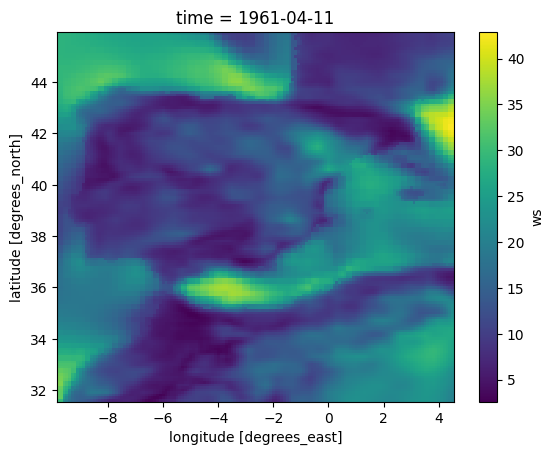

In [19]:
ds_ref['ws'].isel(time=100).plot()

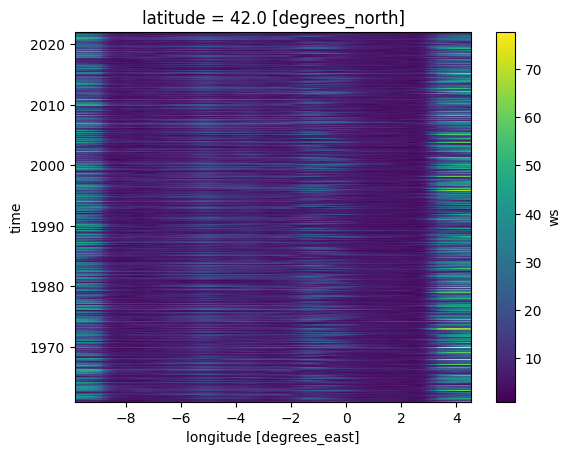

In [16]:
ds_ref['ws'].sel(latitude=42, method="nearest").plot()

#### Utility variables

In [17]:
key_columns = ['ALTITUD', 'LATITUD', 'LONGITUD', 'NOMBRE', 'NOM_PROV']

cuencas = list(range(10)) + ['B', 'C']

column_order = [
    'INDICATIVO', 'NOMBRE', 'NOM_PROV', 'NOM_MUNI', 'ALTITUD', 'LATITUD', 'LONGITUD',
    'C_X', 'C_Y', 'DATUM', 'IND_SYN', 'ALTA', 'BAJA', 'AÑO', 'MES', 'DIA', 'DIR_00', 
    'VEL_00', 'DIR_01', 'VEL_01', 'DIR_02', 'VEL_02', 'DIR_03', 
    'VEL_03', 'DIR_04', 'VEL_04', 'DIR_05', 'VEL_05', 'DIR_06', 'VEL_06', 'DIR_07', 
    'VEL_07', 'DIR_08', 'VEL_08', 'DIR_09', 'VEL_09', 'DIR_10', 'VEL_10', 'DIR_11', 
    'VEL_11', 'DIR_12', 'VEL_12', 'DIR_13', 'VEL_13', 'DIR_14', 'VEL_14', 'DIR_15', 
    'VEL_15', 'DIR_16', 'VEL_16', 'DIR_17', 'VEL_17', 'DIR_18', 'VEL_18', 'DIR_19', 
    'VEL_19', 'DIR_20', 'VEL_20', 'DIR_21', 'VEL_21', 'DIR_22', 'VEL_22', 'DIR_23', 
    'VEL_23', 'R_MAX_DIR', 'R_MAX_VEL', 'R_MAX_HOR', 'DIR_VEL_10', 'VEL_MED_10', 
    'HOR_VEL_10', 'REC24', 'REC77'
    ]    

In [21]:
cuencas

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'B', 'C']

#### Read Observation data

In [22]:
full_data = []

for cuenca in cuencas:
    print(f'Processing data for the cuenca: {cuenca}')
    
    meta_obs_path = os.path.join(OBSERVATION_BASE_PATH, f'MaestroVientoHorario_Cuenca_{cuenca}.csv')
    data_obs_path = os.path.join(OBSERVATION_BASE_PATH, f'VientoHorario_Cuenca_{cuenca}.csv')

    meta_obs = pd.read_csv(meta_obs_path, delimiter=";", encoding="latin1", on_bad_lines="skip")
    data_obs = pd.read_csv(data_obs_path, delimiter=";", encoding="latin1", on_bad_lines="skip")

    #### Remove an extra spaec in INDICATIVO name column
    data_obs = data_obs.rename(columns={' INDICATIVO': 'INDICATIVO'})

    #### Mege metadata and data
    merged_df = pd.merge(meta_obs, data_obs, on='INDICATIVO', suffixes=('_meta', '_data'))

    #### Check if column information match
    for col in key_columns:
        col_df1 = f"{col}_meta"
        col_df2 = f"{col}_data"
        if not (merged_df[col_df1] == merged_df[col_df2]).all():
            mismatch = merged_df[merged_df[col_df1] != merged_df[col_df2]]
            print(f"Error: La columna {col} tiene discrepancias en las siguientes filas:")
            print(mismatch[[col_df1, col_df2]])
            raise ValueError(f"Discrepancias encontradas en la columna {col}")
    
    #### Remove columns duplicates
    merged_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_meta')]
    merged_df.rename(columns={f'{col}_data': col for col in key_columns}, inplace=True)

    #### Change the order of the columns
    merged_df = merged_df[column_order]

    full_data.append(merged_df)

# Convert full_data (list of DataFrames) to a DataFrame
full_data = pd.concat(full_data, ignore_index=True)


Processing data for the cuenca: 0
Processing data for the cuenca: 1
Processing data for the cuenca: 2
Processing data for the cuenca: 3
Processing data for the cuenca: 4
Processing data for the cuenca: 5
Processing data for the cuenca: 6
Processing data for the cuenca: 7
Processing data for the cuenca: 8
Processing data for the cuenca: 9
Processing data for the cuenca: B
Processing data for the cuenca: C


In [23]:
print(full_data.shape)
print()
print(full_data.columns)

(1471477, 72)

Index(['INDICATIVO', 'NOMBRE', 'NOM_PROV', 'NOM_MUNI', 'ALTITUD', 'LATITUD',
       'LONGITUD', 'C_X', 'C_Y', 'DATUM', 'IND_SYN', 'ALTA', 'BAJA', 'AÑO',
       'MES', 'DIA', 'DIR_00', 'VEL_00', 'DIR_01', 'VEL_01', 'DIR_02',
       'VEL_02', 'DIR_03', 'VEL_03', 'DIR_04', 'VEL_04', 'DIR_05', 'VEL_05',
       'DIR_06', 'VEL_06', 'DIR_07', 'VEL_07', 'DIR_08', 'VEL_08', 'DIR_09',
       'VEL_09', 'DIR_10', 'VEL_10', 'DIR_11', 'VEL_11', 'DIR_12', 'VEL_12',
       'DIR_13', 'VEL_13', 'DIR_14', 'VEL_14', 'DIR_15', 'VEL_15', 'DIR_16',
       'VEL_16', 'DIR_17', 'VEL_17', 'DIR_18', 'VEL_18', 'DIR_19', 'VEL_19',
       'DIR_20', 'VEL_20', 'DIR_21', 'VEL_21', 'DIR_22', 'VEL_22', 'DIR_23',
       'VEL_23', 'R_MAX_DIR', 'R_MAX_VEL', 'R_MAX_HOR', 'DIR_VEL_10',
       'VEL_MED_10', 'HOR_VEL_10', 'REC24', 'REC77'],
      dtype='object')


#### Convert string to numbers

In [24]:
full_data["LATITUD"] = full_data["LATITUD"].str.replace(",", ".").astype(float)
full_data["LONGITUD"] = full_data["LONGITUD"].str.replace(",", ".").astype(float)
full_data["VEL_00"] = pd.to_numeric(full_data["VEL_00"], errors='coerce')
full_data["DIR_00"] = pd.to_numeric(full_data["DIR_00"], errors='coerce')

In [8]:
full_data.head()

,INDICATIVO,NOMBRE,NOM_PROV,NOM_MUNI,ALTITUD,LATITUD,LONGITUD,C_X,C_Y,DATUM,...,DIR_23,VEL_23,R_MAX_DIR,R_MAX_VEL,R_MAX_HOR,DIR_VEL_10,VEL_MED_10,HOR_VEL_10,REC24,REC77
0,0002I,VANDELLÒS,TARRAGONA,VANDELLÒS I L'HOSPITALET DE L'INFANT,32,40.958056,0.871389,825831,4541326,ETRS89,...,17.0,3.0,22.0,31.0,320.0,99.0,8.0,9999.0,71.0,261.0
1,0002I,VANDELLÒS,TARRAGONA,VANDELLÒS I L'HOSPITALET DE L'INFANT,32,40.958056,0.871389,825831,4541326,ETRS89,...,29.0,18.0,31.0,78.0,630.0,31.0,38.0,900.0,576.0,438.0
2,0002I,VANDELLÒS,TARRAGONA,VANDELLÒS I L'HOSPITALET DE L'INFANT,32,40.958056,0.871389,825831,4541326,ETRS89,...,32.0,13.0,32.0,34.0,710.0,33.0,18.0,720.0,204.0,167.0
3,0002I,VANDELLÒS,TARRAGONA,VANDELLÒS I L'HOSPITALET DE L'INFANT,32,40.958056,0.871389,825831,4541326,ETRS89,...,0.0,0.0,23.0,22.0,320.0,99.0,10.0,9999.0,87.0,113.0
4,0002I,VANDELLÒS,TARRAGONA,VANDELLÒS I L'HOSPITALET DE L'INFANT,32,40.958056,0.871389,825831,4541326,ETRS89,...,33.0,35.0,26.0,74.0,1640.0,99.0,35.0,9999.0,418.0,548.0


# Transform the Obs to a netCDF file with the same grid as ERA5-Land

#### Get dimensions to create the netCDF file

In [25]:
latitudes = ds_ref.coords['latitude'].values
longitudes = ds_ref.coords['longitude'].values

In [10]:
#start_date = '2019-01-01 00:00'
#end_date = '2024-08-31 23:00'
#end_date = '2019-12-31 23:00'
#date_range = pd.date_range(start=start_date, end=end_date, freq='h')

#### Get the time range of observations

In [26]:
years = full_data['AÑO'].unique()
print('Years: ', years)

Years:  [2019 2020 2021 2022 2023 2024]


In [43]:
full_data.keys()

Index(['INDICATIVO', 'NOMBRE', 'NOM_PROV', 'NOM_MUNI', 'ALTITUD', 'LATITUD',
       'LONGITUD', 'C_X', 'C_Y', 'DATUM', 'IND_SYN', 'ALTA', 'BAJA', 'AÑO',
       'MES', 'DIA', 'DIR_00', 'VEL_00', 'DIR_01', 'VEL_01', 'DIR_02',
       'VEL_02', 'DIR_03', 'VEL_03', 'DIR_04', 'VEL_04', 'DIR_05', 'VEL_05',
       'DIR_06', 'VEL_06', 'DIR_07', 'VEL_07', 'DIR_08', 'VEL_08', 'DIR_09',
       'VEL_09', 'DIR_10', 'VEL_10', 'DIR_11', 'VEL_11', 'DIR_12', 'VEL_12',
       'DIR_13', 'VEL_13', 'DIR_14', 'VEL_14', 'DIR_15', 'VEL_15', 'DIR_16',
       'VEL_16', 'DIR_17', 'VEL_17', 'DIR_18', 'VEL_18', 'DIR_19', 'VEL_19',
       'DIR_20', 'VEL_20', 'DIR_21', 'VEL_21', 'DIR_22', 'VEL_22', 'DIR_23',
       'VEL_23', 'R_MAX_DIR', 'R_MAX_VEL', 'R_MAX_HOR', 'DIR_VEL_10',
       'VEL_MED_10', 'HOR_VEL_10', 'REC24', 'REC77'],
      dtype='object')

In [47]:
full_data['LATITUD']

0          40.958056
1          40.958056
2          40.958056
3          40.958056
4          40.958056
             ...    
1471472    27.756389
1471473    27.756389
1471474    27.756389
1471475    27.756389
1471476    27.756389
Name: LATITUD, Length: 1471477, dtype: float64

#### Filter data per day

In [28]:
times, wind_maps, dir_maps = [], [], []

for year in years:    

    for month in range(1, 13):
        
        if (year == 2024) and (month == 9):
            break

        # Obtener el número de días en el mes
        _, days_in_month = calendar.monthrange(year, month)

        for day in range(1, days_in_month + 1):
            print(f"Datos para {year}-{month:02d}-{day:02d}:")

            for hour in range(24):
                # Create the date variable
                date = pd.Timestamp(year, month, day, hour)
                #print(date)                

                # Variables to select columns
                hour_str = f"{hour:02d}"
                vel_column = f"VEL_{hour_str}"
                dir_column = f"DIR_{hour_str}"
    
                # Filter de data
                #filtered_data = full_data[(full_data['AÑO'] == year) & (full_data['MES'] == month) & (full_data['DIA'] == day)]
                filtered_data = full_data.query("AÑO == @year & MES == @month & DIA == @day")
                if filtered_data.empty:
                    continue

                # Get only the needed columns
                df_hour = filtered_data[['LATITUD', 'LONGITUD', vel_column, dir_column]].dropna()

                # Create a random map
                wind_np = np.full((len(latitudes), len(longitudes)), np.nan, dtype=np.float32)
                dir_np = np.full((len(latitudes), len(longitudes)), np.nan, dtype=np.float32)
                

                # Iterate over the dataframe rows to fill the map
                #for _, row in df_hour.iterrows():
                lat_obs_list = df_hour['LATITUD']
                lon_obs_list = df_hour['LONGITUD']
                vel_obs_list = getattr(df_hour, vel_column)
                dir_obs_list = getattr(df_hour, vel_column)

                for lat_obs, lon_obs, vel_obs, dir_obs in zip(lat_obs_list, lon_obs_list, vel_obs_list, dir_obs_list):
                    # Find position in matrix
                    lat_idx = np.abs(latitudes - lat_obs).argmin()
                    lon_idx = np.abs(longitudes - lon_obs).argmin()

                    # Add values to this position
                    wind_np[lat_idx, lon_idx] = vel_obs
                    dir_np[lat_idx, lon_idx] = dir_obs

                times.append(date)
                wind_maps.append(wind_np)
                dir_maps.append(dir_np)


Datos para 2019-01-01:
Datos para 2019-01-02:
Datos para 2019-01-03:
Datos para 2019-01-04:
Datos para 2019-01-05:
Datos para 2019-01-06:
Datos para 2019-01-07:
Datos para 2019-01-08:
Datos para 2019-01-09:
Datos para 2019-01-10:
Datos para 2019-01-11:
Datos para 2019-01-12:
Datos para 2019-01-13:
Datos para 2019-01-14:
Datos para 2019-01-15:
Datos para 2019-01-16:
Datos para 2019-01-17:
Datos para 2019-01-18:
Datos para 2019-01-19:
Datos para 2019-01-20:
Datos para 2019-01-21:
Datos para 2019-01-22:
Datos para 2019-01-23:
Datos para 2019-01-24:
Datos para 2019-01-25:
Datos para 2019-01-26:
Datos para 2019-01-27:
Datos para 2019-01-28:
Datos para 2019-01-29:
Datos para 2019-01-30:
Datos para 2019-01-31:
Datos para 2019-02-01:
Datos para 2019-02-02:
Datos para 2019-02-03:
Datos para 2019-02-04:
Datos para 2019-02-05:
Datos para 2019-02-06:
Datos para 2019-02-07:
Datos para 2019-02-08:
Datos para 2019-02-09:
Datos para 2019-02-10:
Datos para 2019-02-11:
Datos para 2019-02-12:
Datos para 

In [50]:
filtered_data

,INDICATIVO,NOMBRE,NOM_PROV,NOM_MUNI,ALTITUD,LATITUD,LONGITUD,C_X,C_Y,DATUM,...,DIR_23,VEL_23,R_MAX_DIR,R_MAX_VEL,R_MAX_HOR,DIR_VEL_10,VEL_MED_10,HOR_VEL_10,REC24,REC77
2461,0009X,ALFORJA,TARRAGONA,ALFORJA,406,41.213889,0.963333,832278,4570083,ETRS89,...,0.0,0.0,12.0,28.0,1420.0,99.0,13.0,9999.0,137.0,165.0
4543,0016A,REUS/AEROPUERTO,TARRAGONA,REUS,71,41.145000,1.163611,849439,4563219,ETRS89,...,1.0,9.0,34.0,33.0,819.0,99.0,19.0,9999.0,272.0,281.0
6589,0061X,PONTONS,BARCELONA,PONTONS,632,41.416944,1.519167,877713,4594913,ETRS89,...,0.0,0.0,14.0,29.0,1410.0,14.0,18.0,1610.0,178.0,172.0
8669,0066X,VILAFRANCA DEL PENEDÈS,BARCELONA,VILAFRANCA DEL PENEDÈS,177,41.330278,1.676944,891425,4585989,ETRS89,...,3.0,6.0,10.0,27.0,1430.0,12.0,12.0,1440.0,93.0,97.0
10718,0073X,SITGES-VALLCARCA,BARCELONA,SITGES,58,41.243889,1.852500,906659,4577204,ETRS89,...,0.0,0.0,18.0,27.0,1030.0,17.0,17.0,1140.0,136.0,156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462142,C917E,DEHESA-REFUGIO,SANTA CRUZ DE TENERIFE,FRONTERA,715,27.725278,-18.115000,-999769,3160218,REGCAN95,...,12.0,24.0,10.0,57.0,600.0,99.0,30.0,540.0,516.0,439.0
1465739,C925F,SAN ANDRÉS-DEPÓSITO CABILDO,SANTA CRUZ DE TENERIFE,VALVERDE,1070,27.768611,-17.960000,-983582,3163165,REGCAN95,...,33.0,23.0,32.0,38.0,2340.0,33.0,27.0,2220.0,331.0,311.0
1467290,C928I,VALVERDE,SANTA CRUZ DE TENERIFE,VALVERDE,670,27.810833,-17.919444,-978916,3167427,REGCAN95,...,35.0,26.0,35.0,37.0,2210.0,36.0,27.0,2250.0,443.0,421.0
1469376,C929I,HIERRO/AEROPUERTO,SANTA CRUZ DE TENERIFE,VALVERDE,32,27.818889,-17.888889,-975736,3167955,REGCAN95,...,1.0,34.0,1.0,42.0,2220.0,1.0,35.0,9999.0,566.0,550.0


In [45]:
df_hour

,LATITUD,LONGITUD,VEL_23,DIR_23
2461,41.213889,0.963333,0.0,0.0
4543,41.145000,1.163611,9.0,1.0
6589,41.416944,1.519167,0.0,0.0
8669,41.330278,1.676944,6.0,3.0
10718,41.243889,1.852500,0.0,0.0
...,...,...,...,...
1462142,27.725278,-18.115000,24.0,12.0
1465739,27.768611,-17.960000,23.0,33.0
1467290,27.810833,-17.919444,26.0,35.0
1469376,27.818889,-17.888889,34.0,1.0


In [48]:
lat_obs

27.756389

#### Concatenate data

In [49]:
wind_maps

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [ 8., nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [ 8., nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [10., nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [51]:
wind_maps = np.stack(wind_maps, axis=0)
dir_maps = np.stack(dir_maps, axis=0)

: 

#### Create DataArrays

In [14]:
wind_maps_da = xr.DataArray(
    np.stack(wind_maps),
    dims=("time", "latitude", "longitude"),
    coords={"time": times, "latitude": latitudes, "longitude": longitudes},
    name="ws"
)

dir_maps_da = xr.DataArray(
    np.stack(dir_maps),
    dims=("time", "latitude", "longitude"),
    coords={"time": times, "latitude": latitudes, "longitude": longitudes},
    name="dir"
)

#### Create the Dataset

In [15]:
ws_ds = xr.Dataset({"ws": wind_maps_da, "dir": dir_maps_da})

#### Save data

In [16]:
ws_ds.to_netcdf(os.path.join(CURRENT_DIR, f"AEMET_Hourly_kmh_144x144_9km.nc"))

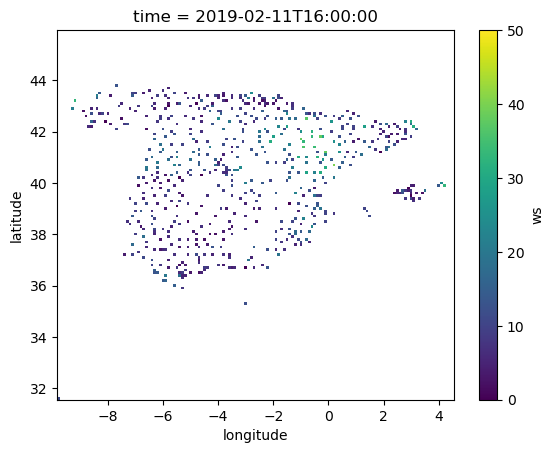

In [23]:
ws_ds['ws'].isel(time=1000).plot(vmin=0, vmax=50)

In [25]:
ws = ws_ds["ws"]
dir = ws_ds["dir"]

In [26]:
print(ws.mean().item())
print(ws.std().item())
print(ws.min().item())
print(ws.max().item())

8.879003524780273
7.6876959800720215
0.0
139.0


In [49]:
import matplotlib.pyplot as plt

non_nan_count = ws.notnull().sum(dim=['latitude', 'longitude'])

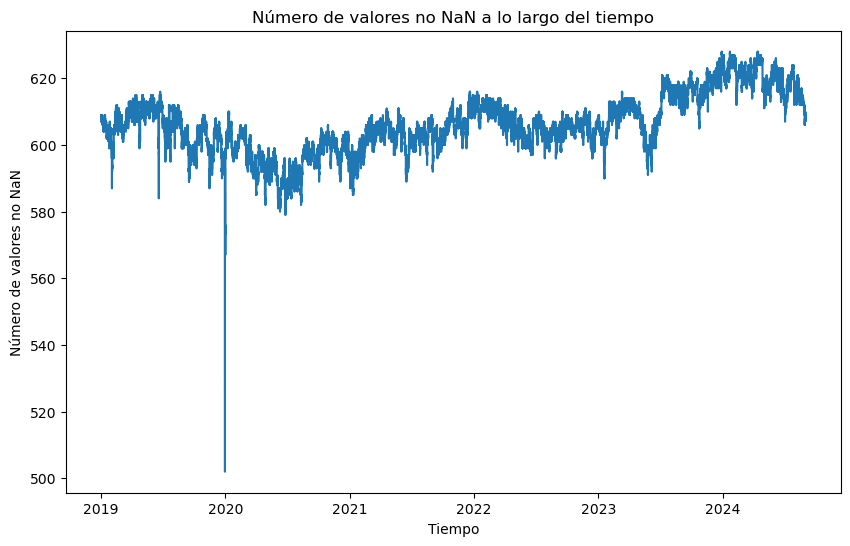

In [50]:
plt.figure(figsize=(10, 6))
non_nan_count.plot()
plt.title("Número de valores no NaN a lo largo del tiempo")
plt.xlabel("Tiempo")
plt.ylabel("Número de valores no NaN")
plt.show()

In [71]:
min_non_nan_time = non_nan_count.idxmin()
print(min_non_nan_time.values)
non_nan_count_series = non_nan_count.to_series()
top_10_min_times = non_nan_count_series.nsmallest(30)
print(top_10_min_times)

2019-12-30T18:00:00.000000000
time
2019-12-30 18:00:00    502
2019-12-31 23:00:00    567
2019-12-31 06:00:00    573
2019-12-30 17:00:00    574
2019-12-31 08:00:00    574
2019-12-31 12:00:00    574
2019-12-31 17:00:00    574
2019-12-31 22:00:00    574
2019-12-31 00:00:00    575
2019-12-31 03:00:00    575
2019-12-31 07:00:00    575
2019-12-31 10:00:00    575
2019-12-31 11:00:00    575
2019-12-31 13:00:00    575
2019-12-31 16:00:00    575
2019-12-31 18:00:00    575
2019-12-31 19:00:00    575
2019-12-31 01:00:00    576
2019-12-31 02:00:00    576
2019-12-31 04:00:00    576
2019-12-31 05:00:00    576
2019-12-31 09:00:00    576
2019-12-31 14:00:00    576
2019-12-31 15:00:00    576
2019-12-31 20:00:00    576
2019-12-31 21:00:00    576
2019-12-30 15:00:00    578
2019-12-30 16:00:00    578
2020-06-25 11:00:00    579
2020-06-09 10:00:00    580
Name: ws, dtype: int64


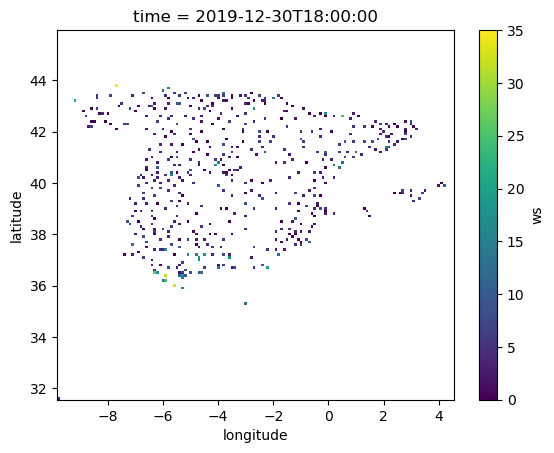

In [72]:
ws.sel(time=min_non_nan_time).plot()

In [73]:
non_nan_count.loc[{ 'time': min_non_nan_time }] = 600

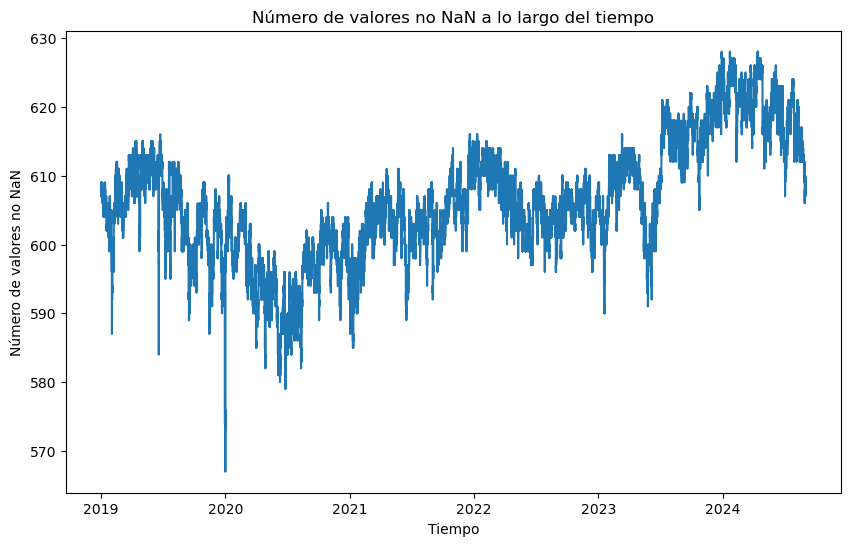

In [74]:
plt.figure(figsize=(10, 6))
non_nan_count.plot()
plt.title("Número de valores no NaN a lo largo del tiempo")
plt.xlabel("Tiempo")
plt.ylabel("Número de valores no NaN")
plt.show()